References:

* https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#
* https://www.hindawi.com/journals/bmri/2014/781670/


In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

In [40]:
data = pd.read_csv('../../../../../../data/diabetic_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

The above shows there are no missing values. Let's examine a few of the records.

In [41]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Above shows there are many values represented by '?'. We'll replace '?' with NAN.

In [42]:
data.replace('?', np.nan, inplace=True)

Find features with missing values.

In [43]:
data.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

Due to the frequency of missing data, let's remove 'weight', 'medical_specialty', and 'payer_code'.

In [44]:
data.drop(columns=["weight","medical_specialty","payer_code"], inplace=True)

Next, let's remove observations where the discharge disposition is related to hospice or death, since these will not add to the possibility of being readmitted.
* 11 - Expired
* 13 - Hospice/Home
* 14 - Hospice/Medical Facility
* 19 - Expired at Home
* 20 - Expired at Medical Facility
* 21 - Expired at Unknown

In [45]:
dispositionsToRemove = ['11','13','14','19','20','21']
data = data[~data.discharge_disposition_id.isin(dispositionsToRemove)]

In the data set, we find that patients have multiple admissions. The paper (referenced above) suggests using only the first one to satisfy the independence assumption. So we will filter and only use the first encounter (the lowest for a given member). I wonder if this could be challenged. If the diagnosis or reason for visit is different than a previous admission, I think it could be considered statistically independent.

The below filters the data frame to use the first encounter for a given member 'patient_nbr'.

In [46]:
def get_min_encounter_id(df):
    min_enc = df.groupby('patient_nbr').encounter_id.transform(min)
    return df[df.encounter_id == min_enc]

data = get_min_encounter_id(data)

Create buckets for the ICD-9 diagnosis codes. We'll use the mapping defined based on the following. https://www.hindawi.com/journals/bmri/2014/781670/tab2/ Regular Expressions are used below to translate the ICD9 codes into buckets

In [47]:
def map_dx(data,regex,replace):
    data['diag_1'] = np.where(data['diag_1'].str.contains(regex,regex=True,na=False),replace,data['diag_1'])
    data['diag_2'] = np.where(data['diag_2'].str.contains(regex,regex=True,na=False),replace,data['diag_2'])
    data['diag_3'] = np.where(data['diag_3'].str.contains(regex,regex=True,na=False),replace,data['diag_3'])

In [48]:
# Circulatory
map_dx(data,'^39[0-9]|^4[0-5][0-9]','Circulatory')
map_dx(data,'^785','Circulatory')

# Respiratory
map_dx(data,'^4[6-9][0-9]|^5[0-1][0-9]','Respiratory')
map_dx(data,'^786','Respiratory')

# Digestive
map_dx(data,'^5[2-7][0-9]','Digestive')
map_dx(data,'^787','Digestive')

# Diabetes
map_dx(data,'^250','Diabetes')

# Injury
map_dx(data,'^[8-9][0-9][0-9]','Injury')

# Musculoskeletal
map_dx(data,'^7[1-3][0-9]','Musculoskeletal')

# Genitourinary
map_dx(data,'^5[8-9][0-9]|^6[0-2][0-9]','Genitourinary')
map_dx(data,'^788','Genitourinary')

# Neoplasms
map_dx(data,'^1[4-9][0-9]|^2[0-7][0-9]','Neoplasms')
map_dx(data,'^78[0-2]|^79[0-9]','Neoplasms')
map_dx(data,'^6[8-9][0-9]|^70[0-9]','Neoplasms')
map_dx(data,'^([1-9]|[1-9][0-9]|1[0-3][0-9])$','Neoplasms')
map_dx(data,'^784','Neoplasms')

# For those that are missing, label as "None"
data['diag_1'].fillna(value="None",inplace=True)
data['diag_2'].fillna(value="None",inplace=True)
data['diag_3'].fillna(value="None",inplace=True)

# For everything else that hasn't been bucketed, label as "Other" 
dxBuckets = ['Circulatory','Respiratory','Digestive','Diabetes','Injury','Musculoskeletal','Genitourinary','Neoplasms']
data['diag_1'] = np.where(~data['diag_1'].isin(dxBuckets),'Other',data['diag_1'])
data['diag_2'] = np.where(~data['diag_2'].isin(dxBuckets),'Other',data['diag_2'])
data['diag_3'] = np.where(~data['diag_3'].isin(dxBuckets),'Other',data['diag_3'])

Let's take a look at the value counts for 'diag_1'

In [49]:
data.diag_1.value_counts()

Circulatory        21390
Neoplasms           9680
Respiratory         9491
Digestive           6488
Diabetes            5748
Other               4992
Injury              4696
Musculoskeletal     4064
Genitourinary       3441
Name: diag_1, dtype: int64

Age is a factor with 10 levels. We are going to bucket these into 3 different groups in a new feature, and remove the old feature.

* 0 - 30
* 30 - 60
* 60 - 100

In [50]:
data['ageGrp'] = np.where(data['age'] == '[0-10)','[0-30]','')
data['ageGrp'] = np.where(data['age'] == '[10-20)','[0-30]',data['ageGrp'])
data['ageGrp'] = np.where(data['age'] == '[20-30)','[0-30]',data['ageGrp'])
data['ageGrp'] = np.where(data['age'] == '[30-40)','[30-60]',data['ageGrp'])
data['ageGrp'] = np.where(data['age'] == '[40-50)','[30-60]',data['ageGrp'])
data['ageGrp'] = np.where(data['age'] == '[50-60)','[30-60]',data['ageGrp'])
data['ageGrp'] = np.where(data['ageGrp'] == '','[60-100]',data['ageGrp'])

ageCounts = data.ageGrp.value_counts()
print(ageCounts)

[60-100]    46311
[30-60]     21871
[0-30]       1808
Name: ageGrp, dtype: int64


Next we'll remove some features that won't be used.

* Age - Replaced with AgeGrp
* There are two medications that have only 1 factor level, "examide" and "citoglipton". We will remove these from the data set.
* Since encounter_id and patient_nbr are identifiers, we will remove these as well.

In [51]:
data.drop(columns=['age','examide','citoglipton','encounter_id','patient_nbr'], inplace=True)

Clean missing race values, label as "Missing"

Caucasian          52305
AfricanAmerican    12627
Missing             1919
Hispanic            1501
Other               1150
Asian                488
Name: race, dtype: int64


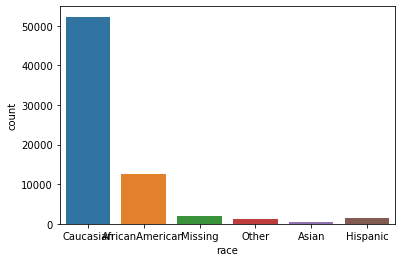

In [52]:
data.race.fillna(value='Missing',inplace=True)
raceCounts = data.race.value_counts()
print(raceCounts)
ax = sns.countplot(x='race',data=data)

There are some levels for discharge disposition that have very few values.

In [53]:
dispositionCounts = data['discharge_disposition_id'].value_counts()
print(dispositionCounts)

1     44322
3      8790
6      8291
18     2474
2      1541
22     1411
5       913
25      778
4       542
7       409
23      260
28       90
8        73
15       40
24       25
9         9
17        8
10        6
27        3
16        3
12        2
Name: discharge_disposition_id, dtype: int64


We'll move ids 9, 10, 17, 27, 16 and 12 in to bucket 25

In [54]:
disBucket = [9,10,12,16,17,27]
data['discharge_disposition_id'] = pd.Categorical(data.discharge_disposition_id)
test = data['discharge_disposition_id'].isin(disBucket)
data['discharge_disposition_id'] = np.where(data['discharge_disposition_id'].isin(disBucket),'25',data['discharge_disposition_id'])
dispositionCounts = data['discharge_disposition_id'].value_counts()
data['discharge_disposition_id'] = pd.Categorical(data.discharge_disposition_id)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69990 entries, 0 to 101765
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      69990 non-null  object  
 1   gender                    69990 non-null  object  
 2   admission_type_id         69990 non-null  int64   
 3   discharge_disposition_id  69990 non-null  category
 4   admission_source_id       69990 non-null  int64   
 5   time_in_hospital          69990 non-null  int64   
 6   num_lab_procedures        69990 non-null  int64   
 7   num_procedures            69990 non-null  int64   
 8   num_medications           69990 non-null  int64   
 9   number_outpatient         69990 non-null  int64   
 10  number_emergency          69990 non-null  int64   
 11  number_inpatient          69990 non-null  int64   
 12  diag_1                    69990 non-null  object  
 13  diag_2                    69990 non-null  obj

Lastly, let's create an outcome column that is Yes if admitted within 30 days, and No for everything else. Then remove the readmitted column. We'll use "outcome" as the response variable.

In [55]:
data['outcome'] = np.where(data['readmitted'] == '<30',1,0)
data.drop(columns=['readmitted'],inplace=True)
outcomeCounts = data['outcome'].value_counts()
print(outcomeCounts)

0    63705
1     6285
Name: outcome, dtype: int64


Above we see that about 10% of our data shows as readmitted, so we have an imbalanced data set. Need to consider that in our analysis later.

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69990 entries, 0 to 101765
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      69990 non-null  object  
 1   gender                    69990 non-null  object  
 2   admission_type_id         69990 non-null  int64   
 3   discharge_disposition_id  69990 non-null  category
 4   admission_source_id       69990 non-null  int64   
 5   time_in_hospital          69990 non-null  int64   
 6   num_lab_procedures        69990 non-null  int64   
 7   num_procedures            69990 non-null  int64   
 8   num_medications           69990 non-null  int64   
 9   number_outpatient         69990 non-null  int64   
 10  number_emergency          69990 non-null  int64   
 11  number_inpatient          69990 non-null  int64   
 12  diag_1                    69990 non-null  object  
 13  diag_2                    69990 non-null  obj

There attributes are shown as numeric, which should be converted to categorical. Additionally, let's convert our objects to categories.

In [57]:
data['admission_type_id'] = pd.Categorical(data.admission_type_id)
data['admission_source_id'] = pd.Categorical(data.admission_source_id)
data['discharge_disposition_id'] = pd.Categorical(data.discharge_disposition_id)

catObjs = data.select_dtypes(include = ['object'])
data[catObjs.columns] = data[catObjs.columns].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69990 entries, 0 to 101765
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      69990 non-null  category
 1   gender                    69990 non-null  category
 2   admission_type_id         69990 non-null  category
 3   discharge_disposition_id  69990 non-null  category
 4   admission_source_id       69990 non-null  category
 5   time_in_hospital          69990 non-null  int64   
 6   num_lab_procedures        69990 non-null  int64   
 7   num_procedures            69990 non-null  int64   
 8   num_medications           69990 non-null  int64   
 9   number_outpatient         69990 non-null  int64   
 10  number_emergency          69990 non-null  int64   
 11  number_inpatient          69990 non-null  int64   
 12  diag_1                    69990 non-null  category
 13  diag_2                    69990 non-null  cat